# Detection of Ransomware Attack Families via Bitcoin Transactions

This is a group project by Master 2 Data Science students at Ecole Polytechnique.

The data used in this study is courtesy of UC Irvine:

    Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

<center><img src="./media/UCI.jpg"/></center>

## 1. Problem Statement

### Ransomware attacks

Starting as early as 1989 with the first documented ransomware known as the AIDS trojan, the use of ransomware scams has grown internationally. Governments worldwide saw a 1,885% increase in ransomware attacks, and the health care industry faced a 755% increase in those attacks in 2021.

A ransomware attack is a virus that infects a computer, a server or a storage device, by temporarily corrupting all of its files with a special encryption. The key to unlock this encryption is only available with the attacker. In exchange for this key, the attacker demands a certain amount of ransom, this is where the attack name derives from.

Over the past four years, the ransom demanded by hackers increased by a shocking 2,966.66 percent. In 2021, the average ransom demand reached **$ 220,298** — up 43 percent compared to 2020. The explosive growth in ransomware demand was in 2019, where the average ransom demand grew 14 times, up **from $6,000 in 2018 to $84,000 by the end of the year**.

### Ransom and Bitcoin &#x20BF;
These payments usually take several forms to be executed. For instance, ransomware attackers usually demand payment to be wired through Western Union or paid through a specialized text message. Some attackers demand payment in the form of gift cards like an Amazon or iTunes Gift Card. Recently, the attackers started asking the victims to purchase the bitcoins required to pay the ransom. The victim sends the money via a bitcoin exchange to the hacker's bitcoin wallet. The criminals confirm payment via email or a Tor site and, if the victim is lucky, will provide the means to decrypt the victim's files. The attackers took advantage of the anonymity provided by the different cryptocurrencies such as Bitcoin, Ethereum or Dogecoin. Even though all transactions are public by nature, user identification is not required to join the network.

People were and still are paying these ransoms due to the importance of their encrypted data. These numbers are even increasing over the years. Especially that the proportion of Cryptolocker (a ransomware) victims claim to have agreed to pay the ransom to recover their files (41%) seems to be much larger than expected (3% was conjectured by Symantec, 0.4% by Dell SecureWorks).

### Taking action
Many studies were conducted in order to tackle this problem and try to reduce its effects on users of the world wide web. The majority of these studies were based on pre-set filtering and pre-defined rules to decide whether a party is an attacker or not.The goal was to track the different ransomware attack families in order to limit their actions and proceed to label them as malicious.

In this challenge, the goal will be to create a model that is able to detect whether the given addresses belong to any of the attacker families by tracing the cryptocurrency transactions in the entire Bitcoin transaction graph from 2009 to 2018.

## 2. Data Exploration

The data used contains the entire Bitcoin transaction graph from 2009 January to 2018 December. Using a time interval of 24 hours, the dataset contains daily transactions on the network forming the Bitcoin graph. Network edges that transfer **less than &#x20BF;0.3** (read: 0.3 bitcoins) were filtered out since ransom amounts are rarely below this threshold.

We created a union of datasets from three widely adopted studies: Montreal, Princeton and Padua. The combined dataset contains **24,486 addresses** from **27 ransomware families**.

### Extracted features

We extract from the graph of Bitcoin transactions a number of features that are resampled on a 24-hour frame.

Using the graph topology, we define the following features:
<ul>
    <li>income</li>
    <li>neighbors</li>
    <li>weight</li>
    <li>length</li>
    <li>count</li>
    <li>loop</li>
</ul>

Let's explain how we get each feature and what do they mean. In order to do so, we must at first define the directed graph G = (V, E), where:

- V are the vertices that represent a user, in our case each user is represented by an address e.g. the hash of the user's nickname
- E are the edges that represent a part of a transaction, originating from an output address $a_{out}$ and is directed towards an input address $a_{in}$. 

**N.B.:** We note that a full transaction can contain more than one input address $a_{in}$, i.e. it can be formed of more than one edge originating from the same or from different output addresses $a_{out}$.

This structure of G is called an address-transaction structure, which represents all the transactions done between all the different users in the blockchain, in our case Bitcoin, between 2009 January and 2018 December.

Hence, we define the **income** of an address $u$ as the total amount of coins output to $u$, i.e. the sum of all the edges that have an input address $a_{in}$ equal to $u$.

Also, we denote the **neighbors** of an address $u$ the number of transactions which have $u$ as one of its output addresses $a_{out}$, i.e. the number of distinct addresses that u has sent money towards.

While the first two features were cumulative i.e. they can grow over time in the graph, the remaining features are extracted from the graph basing on the specific 24-hour interval.

To better understand how we extract these features from the graph, we need to introduce the concept of a *starter transaction*.

We consider a window $w$ of 24 hours interval, where we have a number of transactions that happen in each hour of this window $w$. We mark the timestamp of the earliest transaction done in this window as $t$. We define the set of all the output transactions that are originated before the timestamp $t$ as $TX_{out}$. In this case, we can name a transaction as a *starter transaction* if it does not contain any output transaction from the set $TX_{out}$. In other terms, the transaction does not contain an output transaction originating from the current window $w$.

To clarify the image, we give the following example of a window $w$ that contains more than one starter and non-starter transactions:

<center><img src="./media/graph_transactions.jpg"/></center>

Here, we have a toy network of 10 users (addresses) and 7 full transactions. The transactions tx1, tx3, tx4, and tx5 are starter transactions, whereas the other transactions are not. We notice the coin amounts that are shown on the edges, and that the sum of the input transactions is equal to the sum of the output transactions.

Now, we can continue defining the extracted features:

We denote **weight** of an address $u$ the sum of fraction of coins that originate from a starter transaction and reach $u$.

We also define the **loop** of an address $u$ which is the number of starter transactions which are connected to $u$ with more than one directed paths, e.g. in our toy network, the address $a_{10}$ has the loop equal to 1; this is because of the starter transaction tx4 that splits its coins, moves these coins in different paths, and then merge these coins in the same address $a_{10}$.

For the length and count features, we define a **chain** ending at $u$ as an acyclic directed path originating from any starter transaction and ending at address $u$.

So, the **length** of an address $u$ is the number of non-starter transactions on its longest chain. A length of zero implies that the address is an output address of a starter transaction.

Finally, the **count** of an address $u$ is the number of starter transactions which are connected to u through a chain.


### Loading required libraries

This cell should always contain ALL of our imports.

In [ ]:
import os
import warnings
import pickle
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

from scipy import stats
from scipy.stats import boxcox
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss, plot_roc_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV

from prettytable import PrettyTable
from pprint import pprint

warnings.filterwarnings("ignore")

### Data load

We'll use the download_data script in order to download our BitcoinHeist data.


In [ ]:
!python download_data.py

### Loading the data

We have 2916697 examples in hand that we split into training and testing datasets as follows :


*   The training dataset contains 75% of the original dataset. It is accessible in CSV format under the train folder.

*   The testing dataset contains 25% of the original dataset. It is accessible in CSV format under the test folder.



The next function allows us to load the training and testing datasets.

In [ ]:
from glob import glob

def get_file_list_from_dir(*, path, datadir):
    data_files = sorted(glob(os.path.join(path, "data", datadir, "*.csv.gz")))
    return data_files

In [ ]:
#Loading the training dataset
train_files = get_file_list_from_dir(path=".", datadir="train")
dtrain = pd.concat((pd.read_csv(f) for f in train_files))

#Loading the testing dataset
test_files = get_file_list_from_dir(path=".", datadir="test")
dtest = pd.concat((pd.read_csv(f) for f in test_files))


### Dataset insights

In [ ]:
dtrain.head()

In [ ]:
dtrain.shape # the training dataframe has 2 187 523 rows and 10 columns

In [ ]:
dtest.head()

In [ ]:
dtest.shape # the testing dataframe has 729 174 rows and 10 columns

In [ ]:
print(dtrain.columns) #the names of the columns

Index(['address', 'year', 'day', 'length', 'weight', 'count', 'looped',
       'neighbors', 'income', 'label'],
      dtype='object')


In [ ]:
dtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916697 entries, 0 to 2916696
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     float64
 9   label      object 
dtypes: float64(2), int64(6), object(2)
memory usage: 222.5+ MB


In [ ]:
dtrain.describe()

In [ ]:
dtrain.describe(include=object) #so that we can see some descriptive statistices for the object columns as well

As we've seen from the few descriptions of the dataset above, some columns are of type float, some integer and some object. 

We'll now proceed to do some exploratory data analysis to have more insight on our dataset.

### Feature exploration

In this part we'll try to further understand the features in our dataset, mainly the different classes of the labels which is our target variable.

We'll also see if there are any missing values.

In [ ]:
#checking which columns contain NaN values
dtrain.isna().any()

address      False
year         False
day          False
length       False
weight       False
count        False
looped       False
neighbors    False
income       False
label        False
dtype: bool

In [ ]:
dtrain.year.unique() #the information that's available is from .. consecutive years from ... to ...


In [ ]:
dtrain.year.value_counts() #we have almost the same number of info for each year

In [ ]:
dtrain.looped.unique().shape


(10168,)

In [ ]:
dtrain.neighbors.unique().shape

(814,)

In [ ]:
dtrain['count'].unique().shape

(11572,)

We'll focus on our target variable "label" since for the features, there is a lot of variability of the values taken. Thus it won't be helpful to study their unique values. 

We can however see how their values change with regard to the class of the label.

In [ ]:
dtrain.label.unique().shape

(29,)

In [ ]:
dtrain.label.unique()

For the label, we have 29 different values which we can classify in 2 major categories. The white category and the ransomware category containig the rest of the values that are not white. 

In [ ]:
dtrain.loc[dtrain["label"]=="white", "label"].value_counts()

In [ ]:
dtrain.loc[dtrain["label"]!="white", "label"].value_counts()

In [ ]:
df1 = dtrain[dtrain["label"]!="white"]["label"]

In [ ]:
len(df1)

We have .... white labels vs .... non-white lables => imbalanced data.

This should be taken into consideration when choosing
the performance evaluation metric.

In [ ]:
df2 = dtrain[dtrain["label"]!="white"]["year"]

In [ ]:
df2.value_counts() 

We can see that the number of Ransomware varies greatly from one year to another. There are years where it is much greater compared to the rest. This can be seen in the case of the year 2016 where the number of Ransomware peaked.

In [ ]:
df2 = dtrain[dtrain["label"]!="white"]["neighbors"]


In [ ]:
df2.value_counts() #most of the ransomware cases are when the value of neighbors is either 2 or 1

### Feature by feature exploration

As we can see there are many columns don't contain NaN values so we can check if there are duplicates or outliers.

In [ ]:
dtrain.dropna(inplace=True)
dtrain = dtrain.drop_duplicates()  #Drop duplicate Rows
dtrain['address'].value_counts()
n_addresses = list(dtrain['address'].value_counts())

#### Uni-variate Analysis



In [ ]:
print('An address is repeated an average of {} number of times'.format(np.mean(n_addresses)))

An address is repeated an average of 1.108548722109996 number of times


For the same address we have an average of 1.1 of redundancy in our data so for a specific address there is a low probability to see it again or have another parameters for it.

In [ ]:
sns.distplot(dtrain['length'])
plt.title('Distribution of length')

In global view we can see that we have a skewness in mostly all features so to have a better modelling in our algorithm we are trying to fix the skewness and that's by doing complex functions like Sin/ Log and performing a boxcox operation on it.


##### Another Representation of Length/Weight Variables (yeo johanson) : 
Linear Regression, Gaussian Naive Bayes and other type of algorithms for classification are machine learning techniques that assume numerical variables have a Gaussian probability distribution.
Our data might have a Gaussian-like distribution (e.g. almost Gaussian but with outliers or a skew) or a completely different distribution from a Gaussian distribution (e.g. exponential).
As a result, by changing input and/or output variables to have a Gaussian or more-Gaussian distribution, you may be able to improve performance on a wide range of machine learning techniques.

=> we will add other features of those transformations

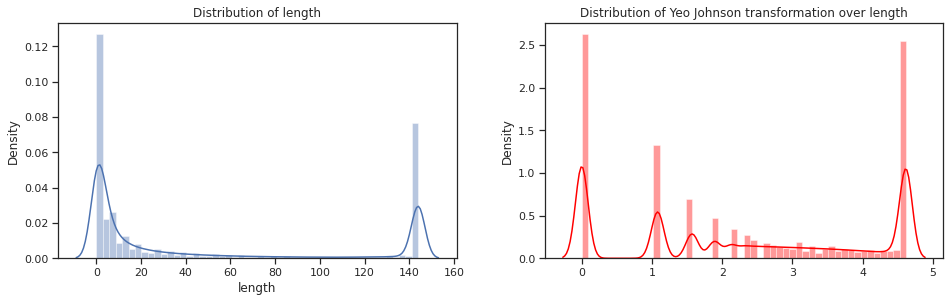

In [ ]:
# Looking at its distribution



plt.figure(figsize=(14, 5))


plt.subplot(121)
sns.distplot(dtrain['length'])
plt.title('Distribution of length')


plt.subplot(122)
sns.distplot(stats.yeojohnson(np.array(dtrain['length']) + 1e-6)[0], color='red')
plt.title('Distribution of Yeo Johnson transformation over length')

plt.tight_layout(pad=3.0)
plt.show()


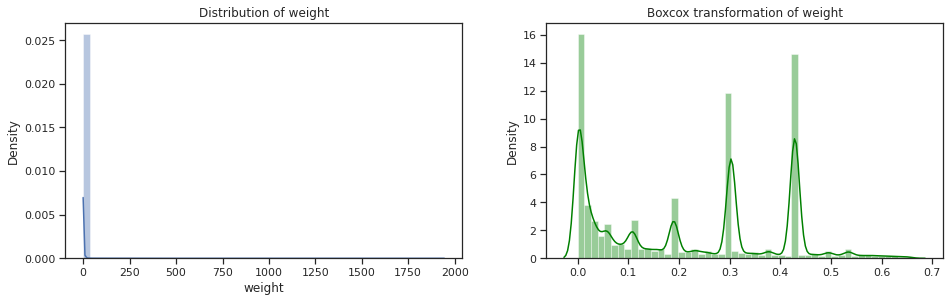

In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(121)
sns.distplot(dtrain['weight'])
plt.title('Distribution of weight')

plt.subplot(122)
sns.distplot(stats.yeojohnson(np.array(dtrain['weight']))[0], color='green')
plt.title('Boxcox transformation of weight')

plt.tight_layout(pad=3.0)
plt.show()

We can see clearly that this transformation and other like it will help in modelling our data in order to push them to some specific algorithms.
In our case the distribution was skewed to the left but after appyling the teo jhonson function we can see that we have a multigaussian distribution with more than 3 normal distrubtions

We can add also interaction features between the length and the weights which will represent complex features for the model that explains the correlation between both of them when comparing to each one mean.

#####  Visualization of the Day Variable

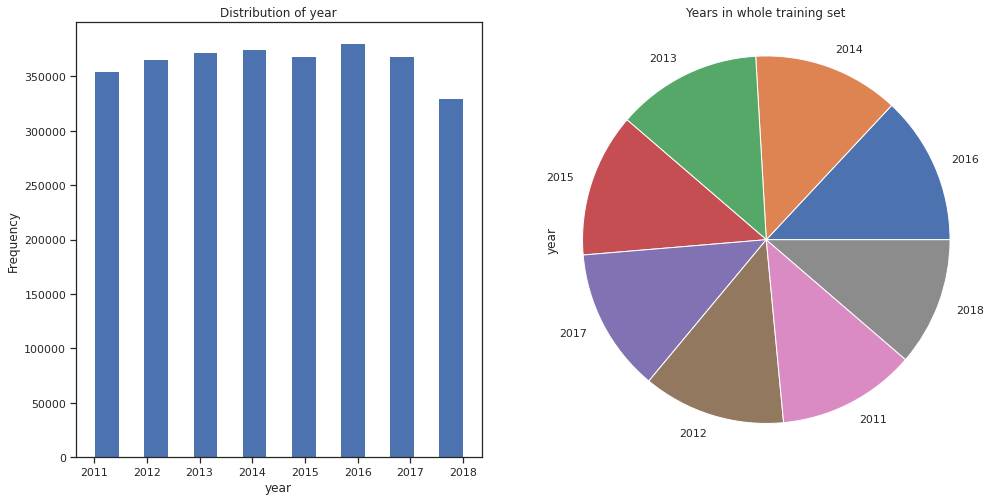

In [ ]:
#Displaying histogram of year feature
plt.figure(figsize=(16, 8))

plt.subplot(121)
dtrain['year'].plot(kind = 'hist', bins=15)
plt.xlabel('year')
plt.title('Distribution of year')

plt.subplot(122)
#displaying pie-chart
dtrain['year'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Years in whole training set')
plt.show()

We can see that the years are approximately distributed uniformly.

In [ ]:
# Splitting data two white and ransomware in order to have a general view on the distribution of the features
Ransomware = dtrain[dtrain['label']!= "white"]
clean = dtrain[dtrain['label']=="white"]

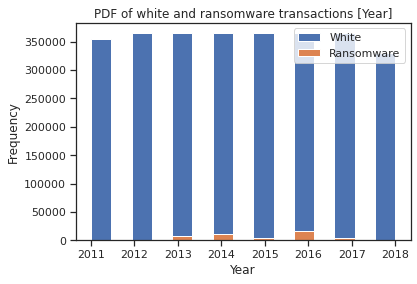

In [ ]:
clean['year'].plot(kind = 'hist', bins=15, label='White')
Ransomware['year'].plot(kind = 'hist', bins=15, label='Ransomware')
plt.xlabel('year')
plt.title('PDF of white and ransomware transactions [Year]')
plt.xlabel('Year')
plt.legend()
plt.show()

Transactions made in 2011 and 2018 are far more likely to be white rather than ransomware and for the rest of the years there is a higher chance to find a Ransomeware transaction. 
So we can conclude that we can discard some dates before pushing them to the algorithm based on their date.

##### Distribution of Variable Day

**The day number of the year in which the transaction took place is shown by this feature.**

**Now consider its distribution and how it influences the target variable.**

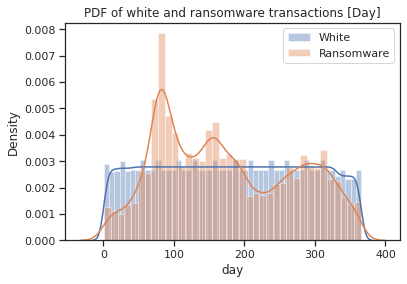

In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(clean['day'], label = 'White')
sns.distplot(Ransomware['day'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Day]')
plt.show()

On certain days, the two roles appear to be separable. On day 95, for example, ransomeware transactions are considerably more probable than white transactions.
it is the same for the days around 150 and 300.

So we can use this information to transform the data in a manner that we are able to seprate the distribution of both classes in a distinguishable way

##### Length

The mixing rounds on Bitcoin are when transactions receive and distribute comparable sums of bitcoin in numerous rounds using freshly established addresses in order to conceal the coin's origin.
Now consider its distribution and how it influences the target variable.

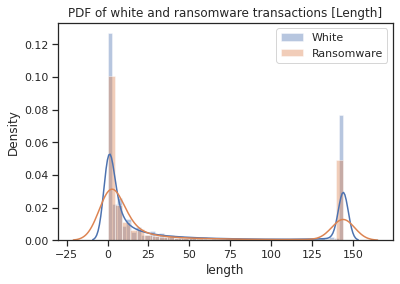

In [ ]:
#plotting pdfs of white and ransomware

sns.distplot(clean['length'], label = 'White')
sns.distplot(Ransomware['length'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Length]')
plt.show()

We can see here that the distribtion of both the White and Ransomware data are indistinguishable so we can not separate well the target using only the Length feature. 

##### Neighbors

The number of neighbors a transaction had is shown by this feature.
Now consider its distribution and how it influences the target variable.


[]

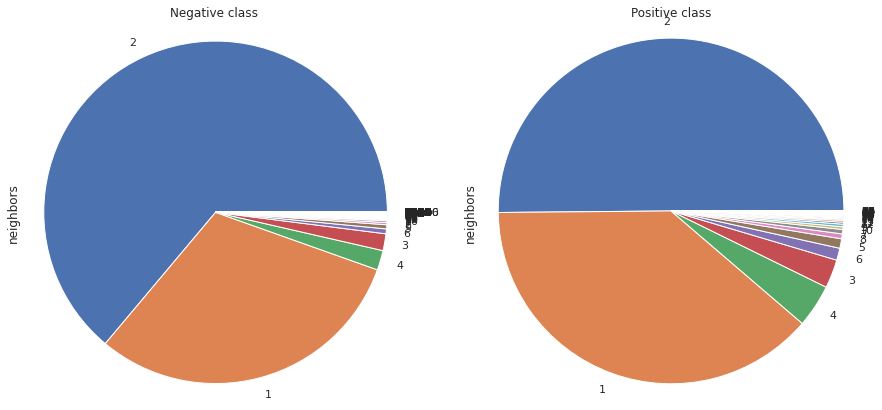

In [ ]:
plt.figure(figsize=(15, 7))

#plotting piechart of negative class
plt.subplot(121)
clean.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Negative class')
plt.plot()


plt.subplot(122)
Ransomware.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Positive class')
plt.plot()

It is clear from the pies that the ransomeware and clean datasets follow different distributions on the neighbors features

Text(0.5, 1.0, 'Percentage of Fraud Detected through Years')

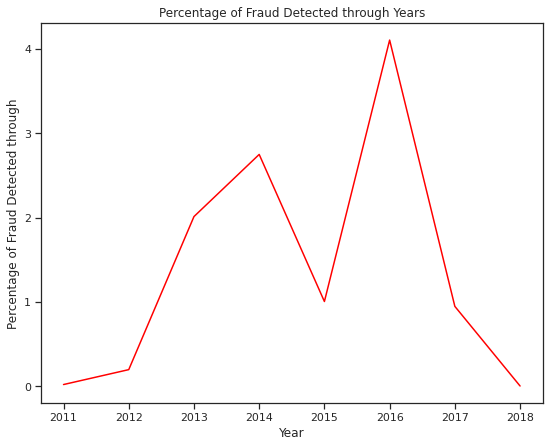

In [ ]:
Count_clean=clean.groupby(['year']).count()
Count_ransomware=Ransomware.groupby(['year']).count()
Percentage = Count_ransomware['label'] /(Count_clean['label']+Count_ransomware['label'])*100
plt.figure(figsize=(9,7))

plt.plot(Percentage,c="red")
plt.xlabel("Year")
plt.ylabel("Percentage of Fraud Detected through")
plt.title("Percentage of Fraud Detected through Years")

In 2016 we see a peak in the ransomware detection addresses and this can be related mainly to the fact that we have an international crises when Greece threatened to leave the European Union in 2015 thus the price of bitcoin increased to reach the triple of its value.

#### Multi-variate Analysis


##### Correlations
A measure of the strength of a linear link between two quantitative variables is called correlation (e.g., height, weight).

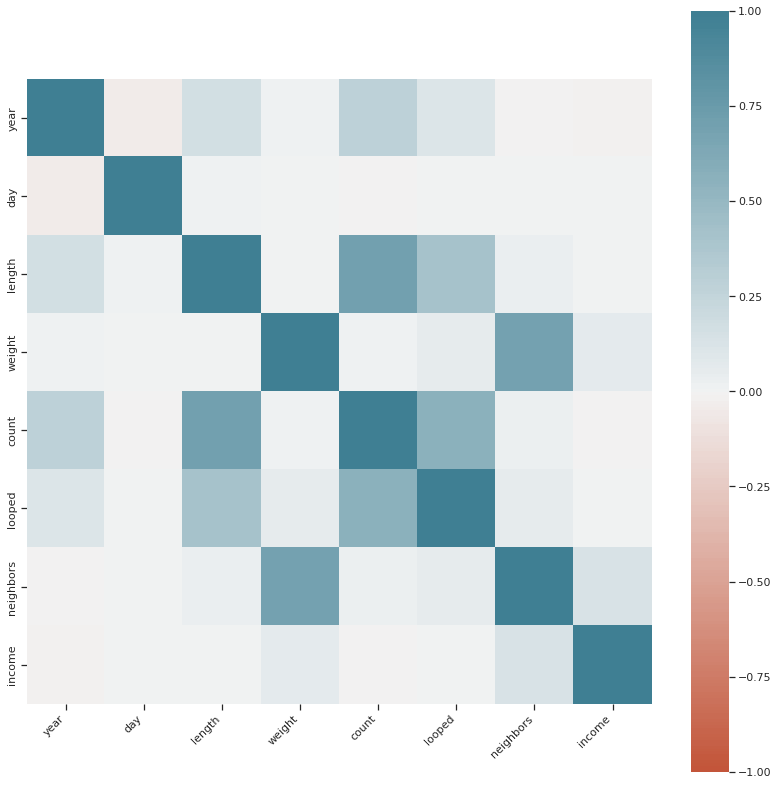

In [ ]:
corr = dtrain.corr()
plt.figure(figsize=(14, 14))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

It shows that the "input" features that mainly decline have a strongly negative correlation in their time variation with almost all the other isotopes which are created in the five years time. Except for example for C and F which behave differently.

##### Pair plots

Pairs plots show how a feature's points are distributed in relation to other features.

[]

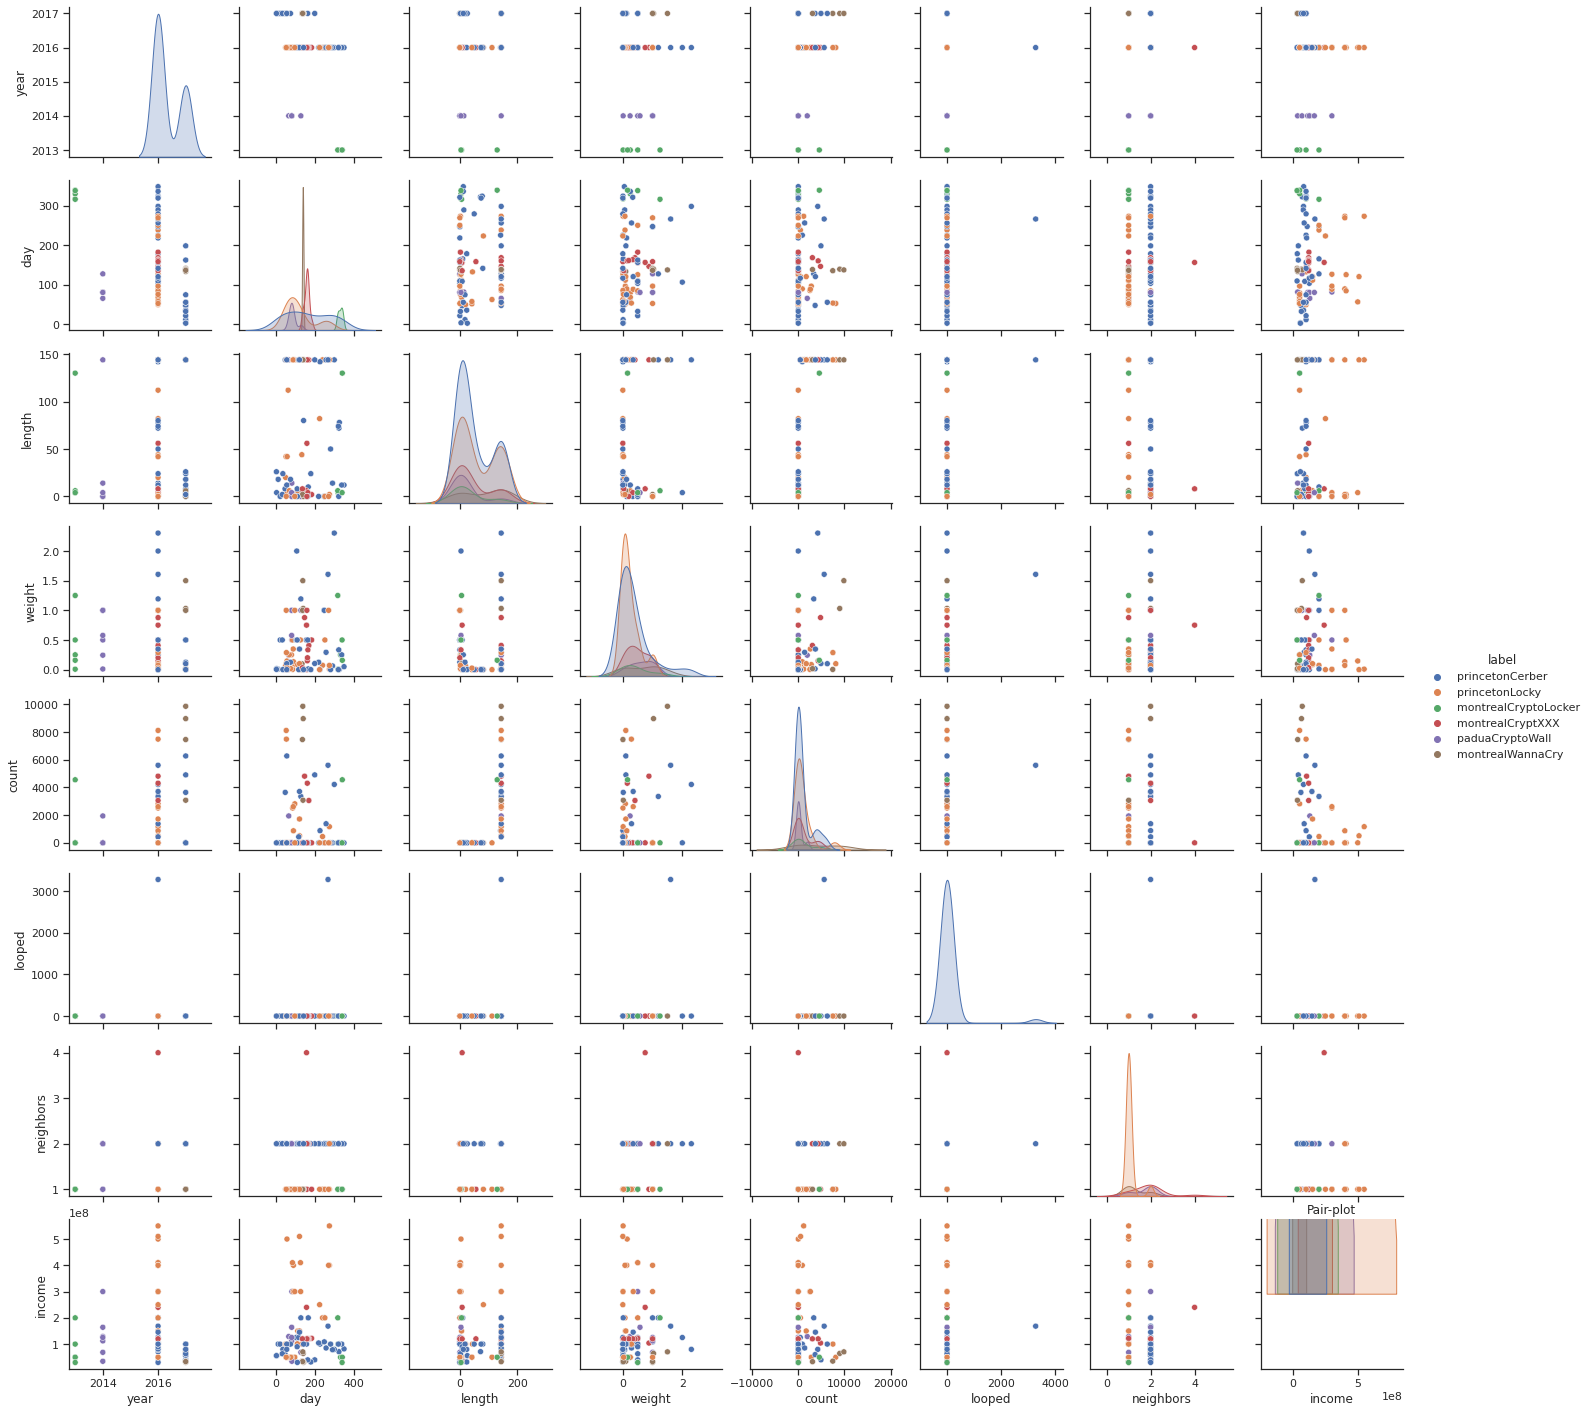

In [ ]:
#plotting pair plots

sns.set_theme(style='ticks')
sns.pairplot(dtrain.iloc[:100], hue='label')
plt.title('Pair-plot')
plt.plot()

A pairs plot shows the distribution of single variables as well as the connections between them. Pair plots are an excellent way to spot tendencies for further investigation.

### Classes exploration

bourhan

## 3. Workflow

Issa, Joel

## 4. Ramp Tutorial

Ronny